In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/imagetc/twitter.png


## Importing Necesseties

In [2]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/imagetc/twitter.png


### Random color function

In [3]:
def random_colours(number_of_colors):
    
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

## Reading the Data

In [4]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
# drop NAN
train.dropna(inplace=True)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## EDA

In [9]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,ad6dc61c8d,Is sad when people`s phones are dead,good,neutral
freq,1,1,199,11117


In [11]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<AxesSubplot:xlabel='sentiment', ylabel='count'>

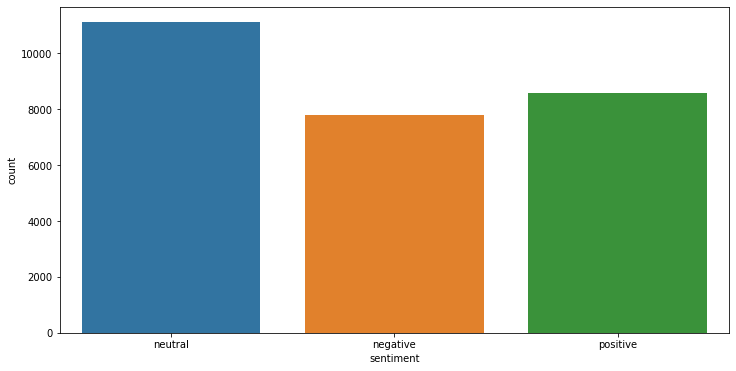

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=train)

### Funnel-Chart for better visualization

In [13]:
fig = go.Figure(go.Funnelarea(
    text = temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [14]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [15]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text
    
    jaccard_score = jaccard(sentence1, sentence2)
    results_jaccard.append([sentence1, sentence2, jaccard_score])

In [16]:
jaccard = pd.DataFrame(results_jaccard, columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard, how='outer')

In [17]:
#Number Of words in Selected Text
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split()))
#Number Of words in main text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split()))
#Difference in Number of words text and Selected Text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST']

In [18]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


Let's look at the distribution of Meta-Features

In [19]:
hist_data = [train['Num_words_ST'], train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

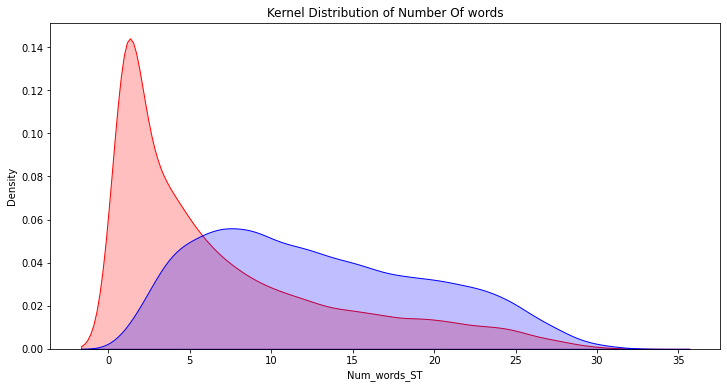

In [20]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

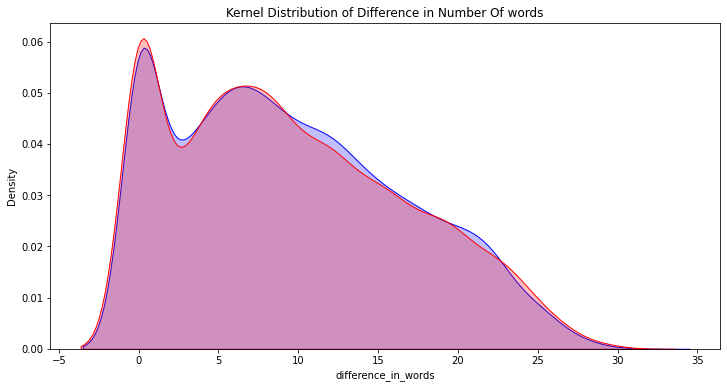

In [21]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'],
               shade=True,
               color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'],
               shade=True,
               color="r")

<AxesSubplot:xlabel='difference_in_words'>

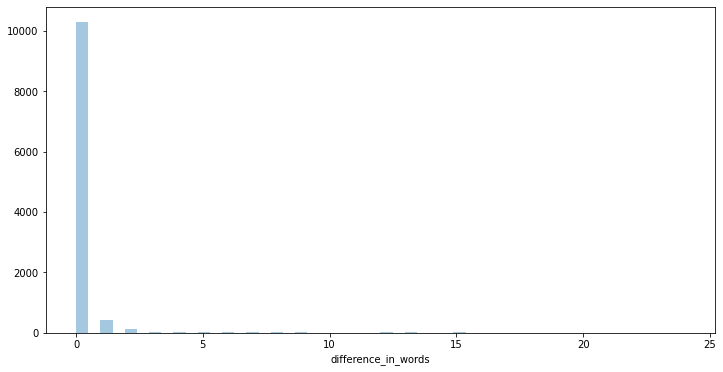

In [22]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'], kde=False)
# text and selected text are mostly the same for neutral tweets.

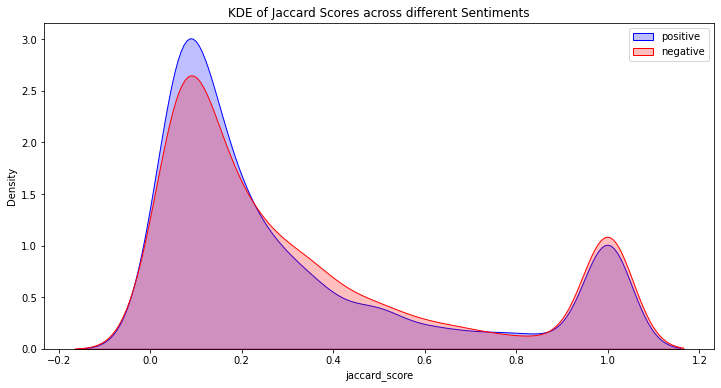

In [23]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'],
               shade=True,
               color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'],
               shade=True,
               color="r")
plt.legend(labels=['positive','negative'])

<AxesSubplot:xlabel='jaccard_score'>

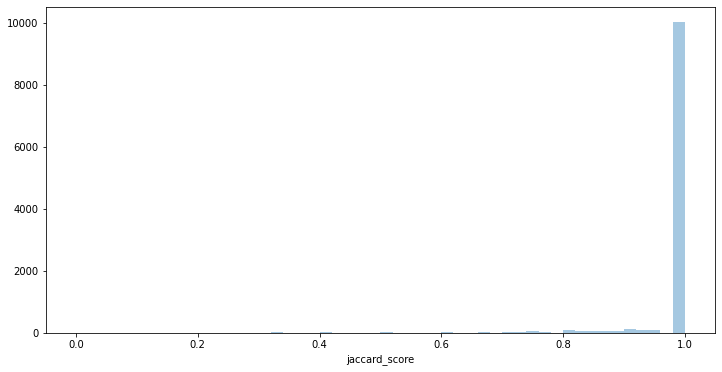

In [24]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'], kde=False)

In [25]:
k = train[train['Num_word_text']<=2]

In [26]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [27]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


### Cleaning the Corpus

In [28]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [29]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [30]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


### Most Common words in our Target-Selected Text

In [31]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [32]:
fig = px.bar(temp, x="count", y="Common_words", title='Common Words in Salected Text', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

### Removing the stopwords

In [33]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [34]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [35]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common Words')
fig.show()

## Most Common words in Text

In [36]:
#List of words in very row for text
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())
#Removing Stopwords
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x))

In [37]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:] # remove im
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [38]:
fig = px.bar(temp, x="count", y="Common_words", title='Common Words in Text', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

## Most common words Sentiments Wise

In [39]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [40]:
#Most common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words', 'count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [41]:
fig = px.bar(temp_positive, x="count", y="Common_words",
             title='Most Common Positive Words',
             orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

In [42]:
#Most common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:] #remove i'm
temp_negative.columns = ['Common_words', 'count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [43]:
fig = px.treemap(temp_negative, path=['Common_words'],
                 values='count',
                 title='Tree Of Most Common Negative Words')
fig.show()

In [44]:
#Most common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.iloc[1:,:] #remove i'm
temp_neutral.columns = ['Common_words', 'count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [45]:
fig = px.bar(temp_neutral,
             x="count", y="Common_words",
             title="Most Common Neutral Words",
             orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

In [46]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',
                 title='Tree Of Most Common Neutral Words')
fig.show()

## Let's Look at Unique Words in each Segment

In [47]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [48]:
def words_unique(sentiment, numwords, raw_words):
    
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother.append(word)
    allother = list(set(allother))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
            
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words', 'count'])
    
    return Unique_words

### Positive Tweets

In [49]:
Unique_Positive = words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [50]:
fig = px.treemap(Unique_Positive, path=['words'],
                 values='count',
                 title='Tree Of Unique Positive Words')
fig.show()

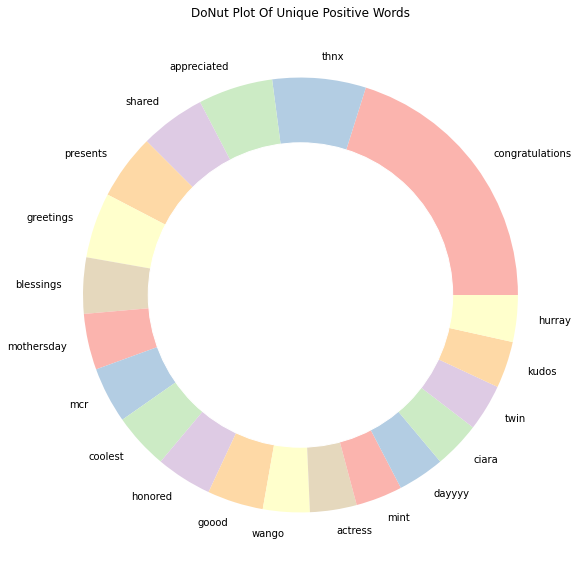

In [51]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words,
        colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [52]:
Unique_Negative = words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


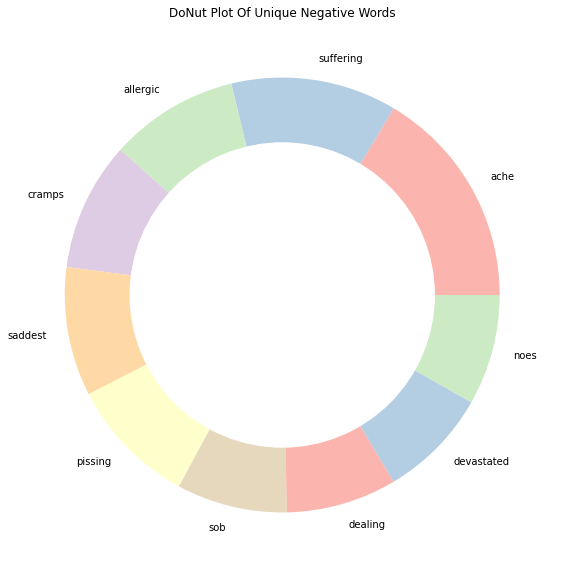

In [53]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words,
        colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [54]:
Unique_Neutral = words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


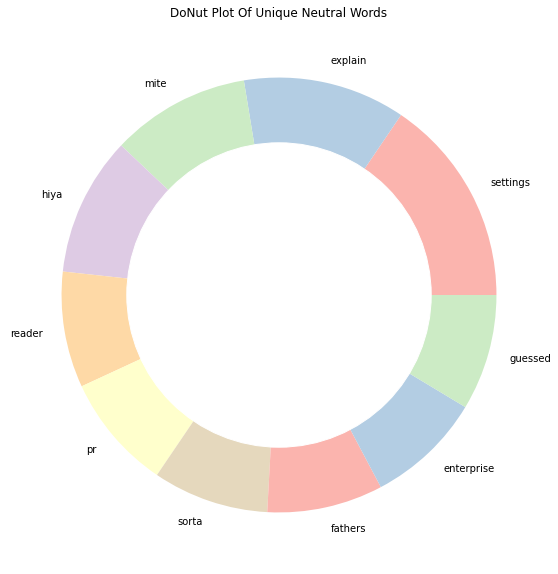

In [55]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words,
        colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

### It's Time For WordClouds

In [56]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color='white', title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)
    
    wordcloud = WordCloud(background_color=color,
                          stopwords = stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size,
                          random_state = 42,
                          width=400,
                          height=200,
                          mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                   'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
d = '/kaggle/input/imagetc/'

### WORDCLOUD OF Neutral tweets

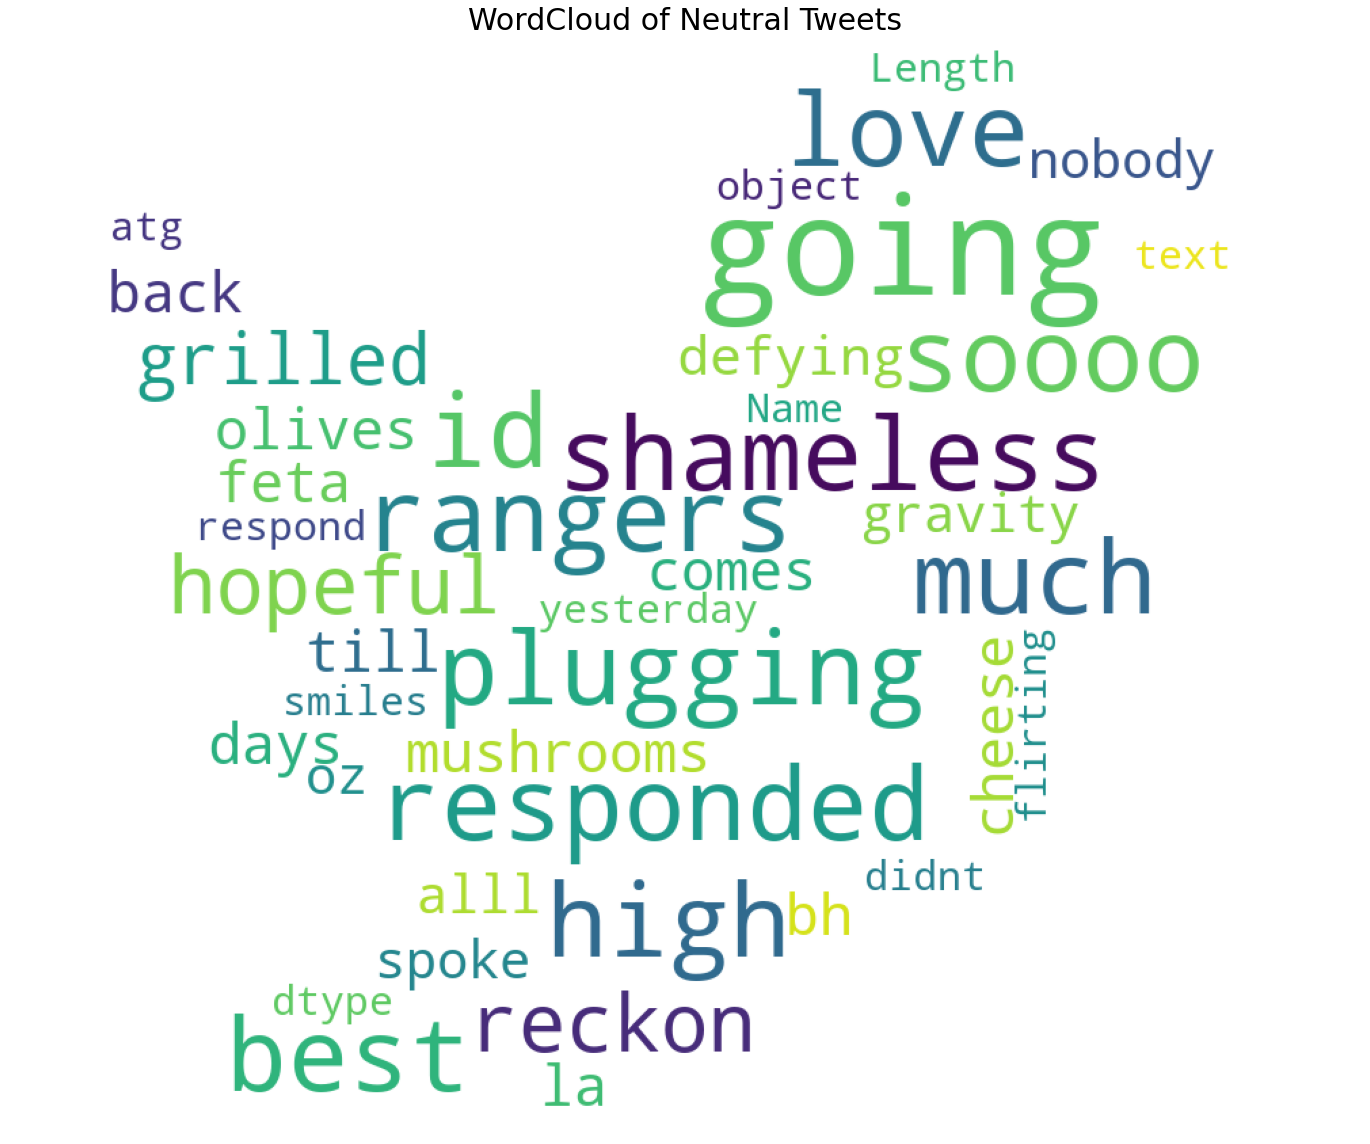

In [57]:
pos_mask = np.array(Image.open(d+ 'twitter.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white', max_font_size=100,
                title_size=30,title="WordCloud of Neutral Tweets")

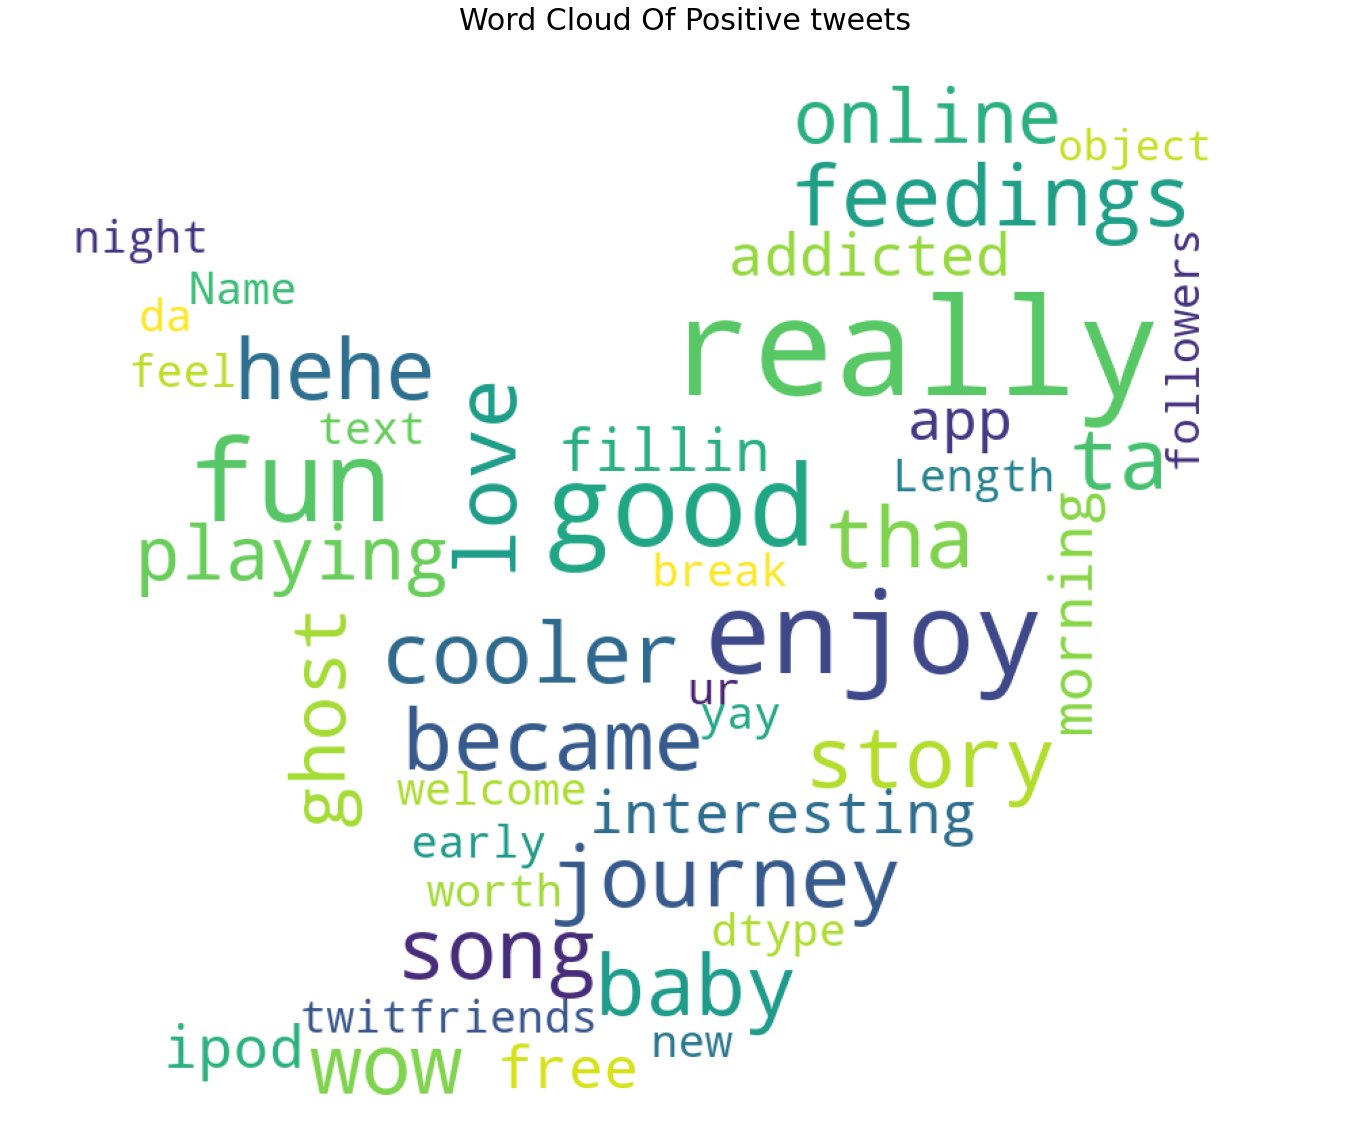

In [58]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

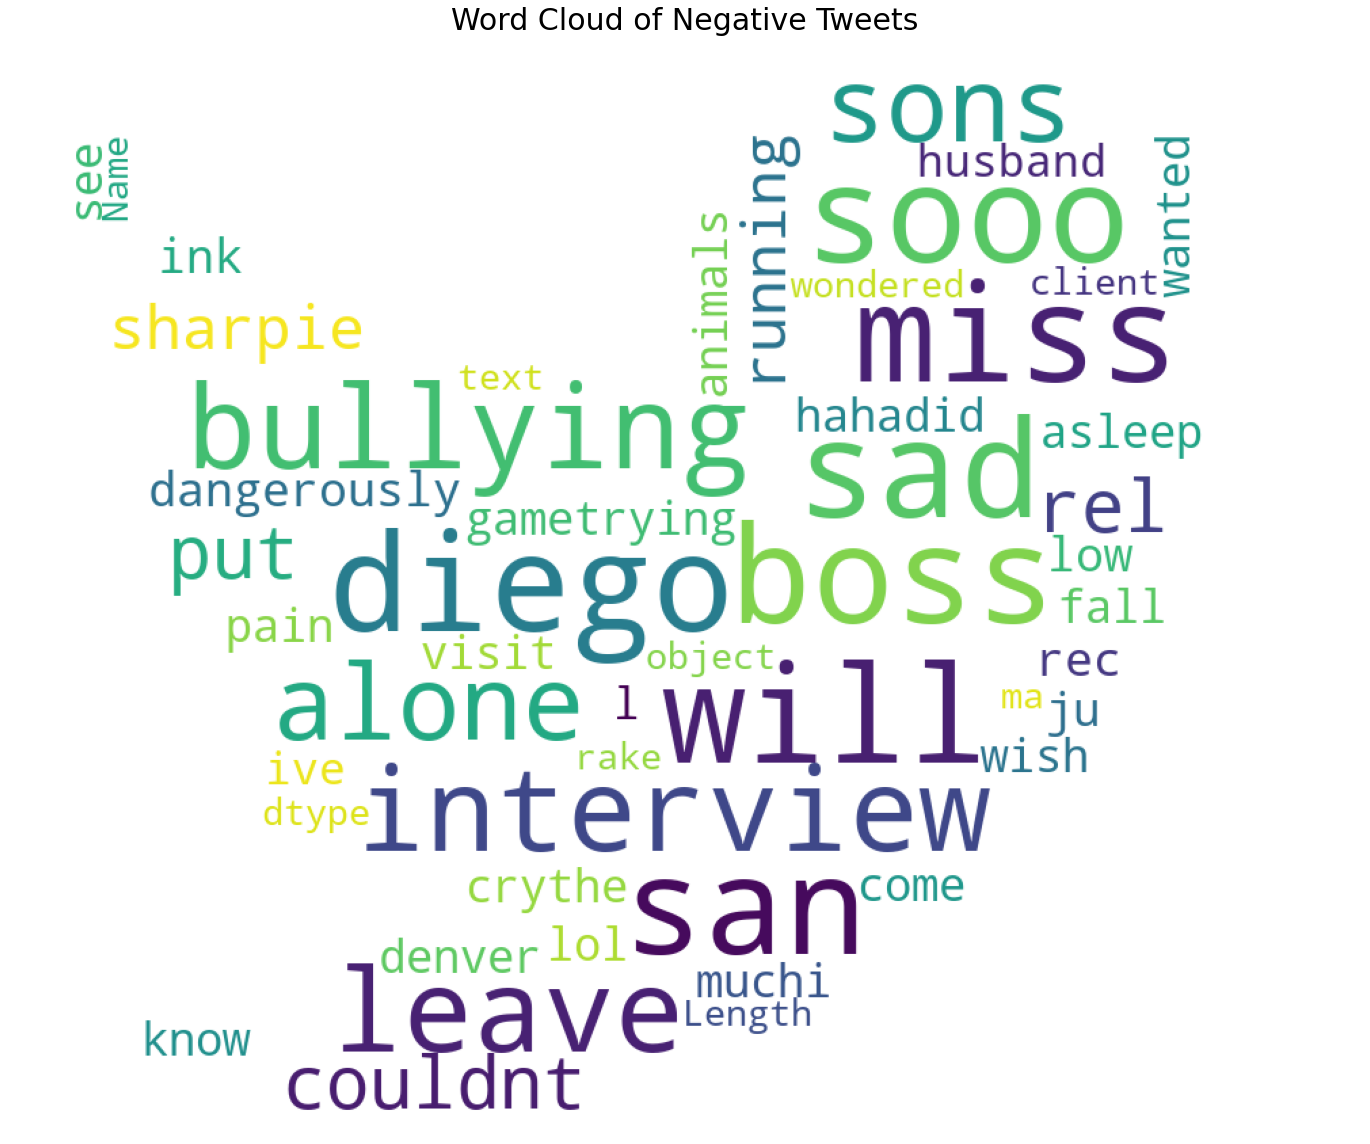

In [59]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets", color='white', title_size=30)

## Modelling

In [60]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [61]:
#Number Of words in main Text in train set
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split()))

In [62]:
df_train = df_train[df_train['Num_words_text']>=3]

In [63]:
def save_model(output_dir, nlp, new_model_name):
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)